In [ ]:
# Modelo sencillo: TF-IDF + Logistic Regression

In [22]:
import os, sys, importlib
sys.path.append(os.path.abspath("..") + "/src")

import preprocessing, train, evaluate, data_loader, utils
importlib.reload(preprocessing)
importlib.reload(train)
importlib.reload(evaluate)
importlib.reload(data_loader)
importlib.reload(utils)

from data_loader import cargar_dataset, dividir_dataset
from preprocessing import preparar_texto, preparar_labels, vectorizar_texto
from train import baseline_train, guardar_modelo
from evaluate import evaluar_modelo
from utils import semilla

semilla(42)


In [23]:
import torch
print(torch.__version__)  #verificar que torch este instalado
print(torch.cuda.is_available())

2.8.0
False


In [25]:
import pandas as pd
df = pd.read_csv("../data/dataset_prepared.csv", sep=",")
df.head()


,title,abstract,group,text,labels_list
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal,Adrenoleukodystrophy: survey of 303 cases: bio...,"['neurological', 'hepatorenal']"
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological,endoscopy reveals ventricular tachycardia secr...,['neurological']
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal,dementia and cholecystitis: organ interplay Pu...,['hepatorenal']
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological,The interpeduncular nucleus regulates nicotine...,['neurological']
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,neurological,guillain-barre syndrome pathways in leukemia H...,['neurological']


In [26]:
train_df, val_df, test_df = dividir_dataset(df, test_size=0.2, val_size=0.1, random_state=42)
len(train_df), len(val_df), len(test_df)

#Dividir en train/val/test (estratificado)

(2566, 286, 713)

In [27]:
#preparar textos

X_train_text = preparar_texto(train_df)
X_val_text   = preparar_texto(val_df)
X_test_text  = preparar_texto(test_df)


In [28]:
#preparar etiquetas multilabel

y_train, mlb = preparar_labels(train_df)
y_val  = mlb.transform(val_df["group"].apply(lambda x: x.split("|")))
y_test = mlb.transform(test_df["group"].apply(lambda x: x.split("|")))

mlb.classes_, y_train.shape

(array(['cardiovascular', 'hepatorenal', 'neurological', 'oncological'],
       dtype=object),
 (2566, 4))

In [29]:
#vectorizar /tf-idf
X_train, vectorizer = vectorizar_texto(X_train_text, max_features=5000)
X_val  = vectorizer.transform(X_val_text)
X_test = vectorizer.transform(X_test_text)

In [30]:
#entrenar baseline /Ovr + Regresion logistica
modelo = baseline_train(X_train, y_train)

Exact Match Ratio: 0.6399
F1 Micro: 0.8006
F1 Macro: 0.7342

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.99      0.72      0.83       102
   hepatorenal       1.00      0.53      0.69        87
  neurological       0.85      0.94      0.89       142
   oncological       1.00      0.35      0.52        48

     micro avg       0.92      0.71      0.80       379
     macro avg       0.96      0.63      0.73       379
  weighted avg       0.94      0.71      0.78       379
   samples avg       0.89      0.78      0.81       379



/Users/juanfe321/Desktop/AGARIANDOREMANDO/Biomedical-Classification-Challenge/biomedical-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juanfe321/Desktop/AGARIANDOREMANDO/Biomedical-Classification-Challenge/biomedical-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


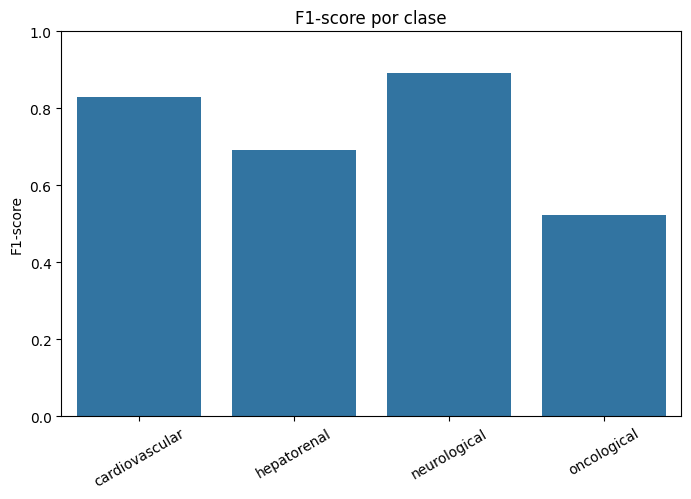

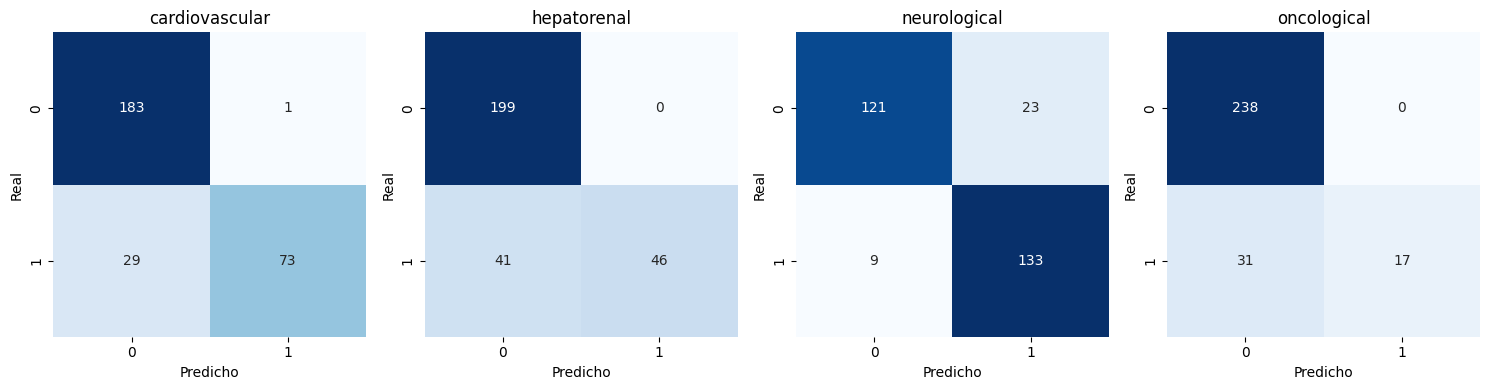

Exact Match Ratio: 0.6550
F1 Micro: 0.8116
F1 Macro: 0.7663

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.98      0.71      0.82       254
   hepatorenal       0.99      0.57      0.73       217
  neurological       0.87      0.91      0.89       358
   oncological       1.00      0.46      0.63       120

     micro avg       0.93      0.72      0.81       949
     macro avg       0.96      0.66      0.77       949
  weighted avg       0.94      0.72      0.80       949
   samples avg       0.89      0.79      0.82       949



/Users/juanfe321/Desktop/AGARIANDOREMANDO/Biomedical-Classification-Challenge/biomedical-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juanfe321/Desktop/AGARIANDOREMANDO/Biomedical-Classification-Challenge/biomedical-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


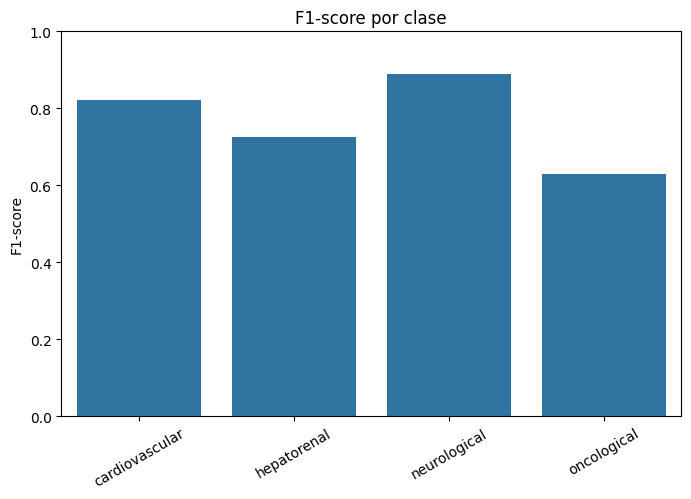

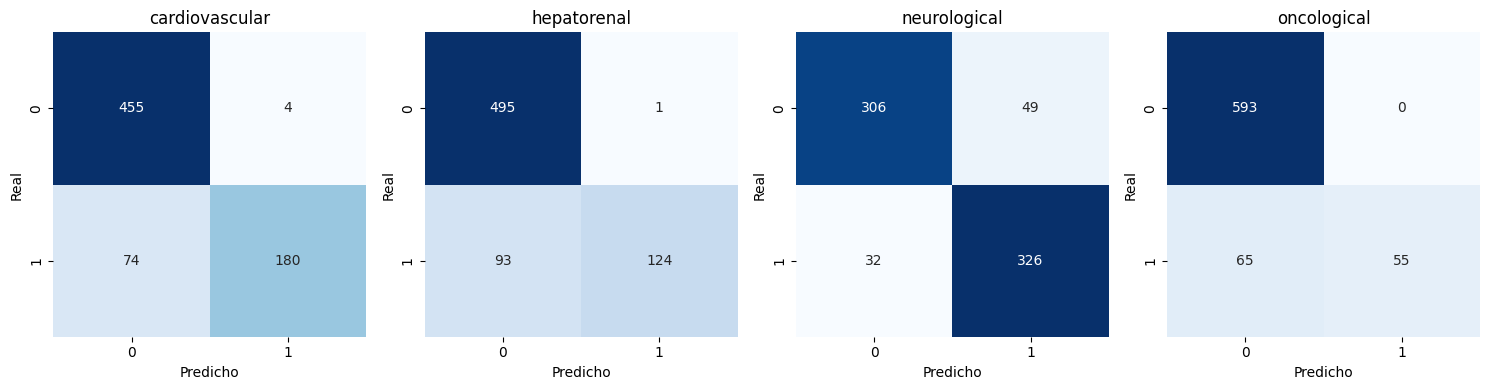

In [31]:
#evaluar (validacion y prueba)
_ = evaluar_modelo(modelo, X_val, y_val, mlb, show_plots=True)
_ = evaluar_modelo(modelo, X_test, y_test, mlb, show_plots=True)

In [32]:
import joblib
guardar_modelo(modelo, "../models/baseline_ovr_logreg.joblib") #modelo entrenado 
joblib.dump(vectorizer, "../models/tfidf_vectorizer.joblib") #vectorizador
joblib.dump(mlb, "../models/labels_mlb.joblib") #binarizador de etiquetas

['../models/labels_mlb.joblib']